# Classification - Determine International Rating 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import math
import re
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Step 1. Prepare data

X:  (3548, 22)
1.0    3245
2.0     219
3.0      70
4.0      14
Name: International Reputation, dtype: int64
n_classes:  4


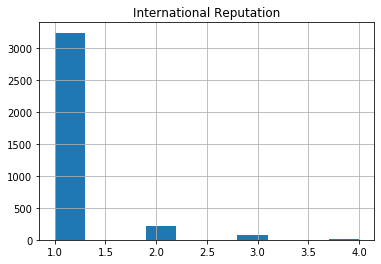

In [3]:
from sklearn.preprocessing import label_binarize

# Read original data
sample_data = pd.read_csv('fifa19_ready_data.csv', encoding='utf-8')
# Remove ID
sample_data = sample_data.drop('ID', axis=1)
# Separate internation rating result with rest
y = sample_data['International Reputation']
X = sample_data.drop('International Reputation', axis=1)
print('X: ', X.shape)

# Binarize the rating result
# Rating score 5 records is only 6 / 18208, so it cannot be predicated with too little data,
# we convert the score 5 to 4, so only choose rating scores 1, 2, 3, 4 to classify.
sample_data['International Reputation'].loc[sample_data['International Reputation'] == 5] = 4
sample_data.hist(column='International Reputation')
print(sample_data['International Reputation'].value_counts())

y = label_binarize(y, classes=[1, 2, 3, 4])
n_classes = y.shape[1]
print('n_classes: ', n_classes)

X_train:  (2365, 22) X_test:  (1183, 22)
Rating Score value counts:  1
1    2169
0     196
dtype: int64


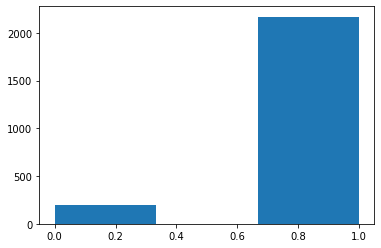

 
Rating Score value counts:  2
0    2220
1     145
dtype: int64


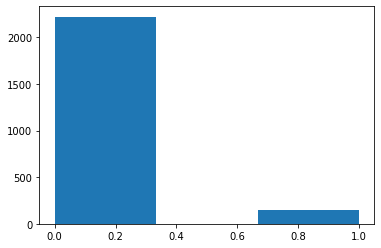

 
Rating Score value counts:  3
0    2322
1      43
dtype: int64


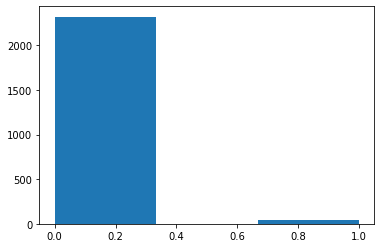

 
Rating Score value counts:  4
0    2357
1       8
dtype: int64


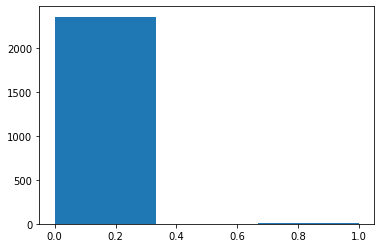

In [4]:
# Divide data into training set and testing set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=1)
print('X_train: ', X_train.shape, 'X_test: ', X_test.shape)

#print(y_train)
for i in range(n_classes):
    print("Rating Score value counts: ", i + 1)
    print(pd.value_counts(y_train[:, i]))
    plt.hist(y_train[:, i], bins=3)
    plt.show()
    print(" ")


In [5]:
# Standardize records
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 
print('X_train: ', X_train.shape, 'X_test: ', X_test.shape)

X_train:  (2365, 22) X_test:  (1183, 22)


In [6]:
# Step 2. Solve with Logistic Regression

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle

# Create function to store ROC computation results for all classification classes
def compute_roc_auc_in_classes(test_data, test_result, num_classes=n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    roc_result = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc }
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(test_data[:, i], test_result[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(test_data.ravel(), test_result.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    # Compute macro-average ROC curve and ROC area
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    return roc_result

# Draw ROC plot based on ROC computation result
def draw_roc_auc_in_classes(roc_auc_result, learn_method, num_classes=n_classes):
    fpr = roc_auc_result['fpr']
    tpr = roc_auc_result['tpr']
    roc_auc = roc_auc_result['roc_auc']
    
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["macro"], tpr["macro"],
             label='Average ROC (area = {0:0.4f})'.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1,
                 label='ROC of rating {0} (area = {1:0.4f})'.format((i + 1), roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for {}'.format(learn_method))
    plt.legend(loc="lower right")
    plt.show()

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# create logistic regression model for multi-class and one vs rest mode
logreg = OneVsRestClassifier(LogisticRegression(solver='sag', multi_class='ovr', random_state=1))
#print("parameters: ", logreg.get_params().keys())

# Create GridSearch to find best model
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

penalty = ['l2']
solver = ['sag', 'saga']
C = [0.0001, 0.001, 0.01, 1, 100, 1000]
hyperparameters = dict(estimator__C=C, estimator__penalty=penalty, estimator__solver=solver)

# Fit model using gridsearch
grid_logreg = GridSearchCV(logreg, hyperparameters, scoring = 'f1_macro', verbose=0)

# Best model
best_logreg = grid_logreg.fit(X_train, y_train)

#Print all the Parameters that gave the best results:
print('Best Parameters',grid_logreg.best_params_)


Best Parameters {'estimator__C': 100, 'estimator__penalty': 'l2', 'estimator__solver': 'sag'}


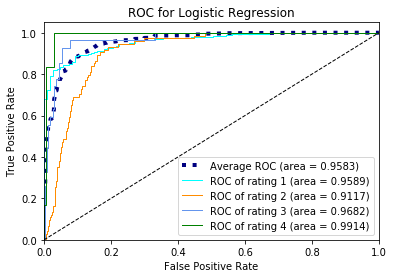

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

# Compute test scores
y_score = best_logreg.fit(X_train, y_train).decision_function(X_test)

# Compute ROC AUC score
logreg_result = compute_roc_auc_in_classes(y_test, y_score, num_classes=n_classes)

# Draw ROC plot
draw_roc_auc_in_classes(logreg_result, 'Logistic Regression', num_classes=n_classes)


In [28]:
# Assign Best score
roc_logreg = logreg_result['roc_auc']['macro']
print("Best ROC score for logistic regression: {0:0.4f}".format(roc_logreg))

Best ROC score for logistic regression: 0.9583


In [40]:
# Step 3. Solve with Naive Bayes

In [32]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
import time

def show_time_spent(start_time):
    time_used = time.time() - start_time
    return "{}:{}:{}".format(int(time_used / 3600), int(time_used % 3600 / 60), int(time_used % 60))

kernel = 1.0 * RBF(1.0)

# create Naive Bayes model for multi-class and one vs rest mode
gaussian_proc = OneVsRestClassifier(GaussianProcessClassifier(kernel=kernel, warm_start=True, 
                                                              multi_class='“one_vs_rest', random_state=1))
print('Created gaussian_proc')
#rint("parameters: ", gaussian_proc.get_params().keys())

# Create GridSearch to find best model
max_iter = [10, 20, 30, 40, 100, 200]
hyperparameters = dict(estimator__max_iter_predict=max_iter)

# Fit model using gridsearch
grid_gaussian_proc = GridSearchCV(gaussian_proc, hyperparameters, scoring = 'f1_macro', verbose=0)

Created gaussian_proc
parameters:  dict_keys(['estimator__copy_X_train', 'estimator__kernel__k1', 'estimator__kernel__k2', 'estimator__kernel__k1__constant_value', 'estimator__kernel__k1__constant_value_bounds', 'estimator__kernel__k2__length_scale', 'estimator__kernel__k2__length_scale_bounds', 'estimator__kernel', 'estimator__max_iter_predict', 'estimator__multi_class', 'estimator__n_jobs', 'estimator__n_restarts_optimizer', 'estimator__optimizer', 'estimator__random_state', 'estimator__warm_start', 'estimator', 'n_jobs'])


In [33]:
# Compute test scores
timer_check = time.time()
print('start training')

# Best model
best_gaussian_proc = grid_gaussian_proc.fit(X_train, y_train)

#Print all the Parameters that gave the best results:
print('Best Parameters', grid_gaussian_proc.best_params_)

print('training spent: ', show_time_spent(timer_check))

start training
Best Parameters {'estimator__max_iter_predict': 20}
training spent:  0:14:40


In [35]:
#timer_check = time.time()
print('start testing')
y_pred_proba = best_gaussian_proc.predict_proba(X_test)
#print('testing spent: ', show_time_spent(timer_check))
print('y_pred_proba: ', y_pred_proba.shape)

start testing
y_pred_proba:  (1183, 4)


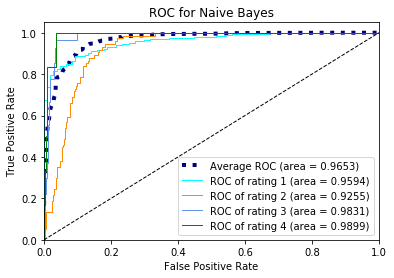

In [36]:
# Compute ROC AUC score
gaussion_proc_result = compute_roc_auc_in_classes(y_test, y_pred_proba, num_classes=n_classes)

# Draw ROC plot
draw_roc_auc_in_classes(gaussion_proc_result, 'Naive Bayes', num_classes=n_classes)

In [37]:
# Assign Best ROC value
roc_gaussian_proc = gaussion_proc_result['roc_auc']["macro"]
print('Best ROC score for Naive Bayes: {0:0.4f}'.format(roc_gaussian_proc))

Best ROC score for Naive Bayes: 0.9653


In [38]:
# Step 4. Solve with Decision Tree

In [68]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

# create Decision Tree model for multi-class and one vs rest mode
decision_tree = OneVsRestClassifier(DecisionTreeClassifier(random_state=1))
print('Created decision_tree')
#print("parameters: ", decision_tree.get_params().keys())

# Create GridSearch to find best model
criterion = ['entropy', 'gini']
max_depth = [ 3, 4, 5, 6, 7, 8, 9, 10]
hyperparameters = dict(estimator__criterion=criterion, estimator__max_depth=max_depth)

# Fit model using gridsearch
grid_decision_tree = GridSearchCV(decision_tree, hyperparameters, scoring = 'roc_auc', verbose=0)
#print(sorted(metrics.SCORERS.keys()))

Created decision_tree


In [69]:
# Best model
best_decision_tree = grid_decision_tree.fit(X_train, y_train)

#Print all the Parameters that gave the best results:
print('Best Parameters', grid_decision_tree.best_params_)

# Compute test scores
y_pred_proba = best_decision_tree.predict_proba(X_test)
print('y_pred_proba: ', y_pred_proba.shape)

Best Parameters {'estimator__criterion': 'entropy', 'estimator__max_depth': 3}
y_pred_proba:  (1183, 4)


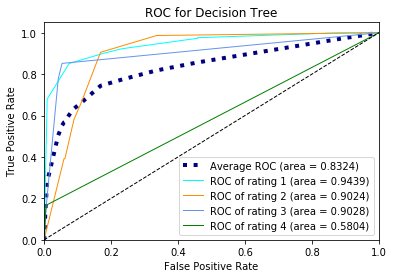

In [70]:
# Compute ROC AUC score
decision_tree_result = compute_roc_auc_in_classes(y_test, y_pred_proba, num_classes=n_classes)

# Draw ROC plot
draw_roc_auc_in_classes(decision_tree_result, 'Decision Tree', num_classes=n_classes)

In [71]:
# Assign Best ROC value
roc_decision_tree = decision_tree_result['roc_auc']["macro"]
print('Best ROC score for Decision Tree: {0:0.4f}'.format(roc_decision_tree))

Best ROC score for Decision Tree: 0.8324


Decision Tree for rating score  1


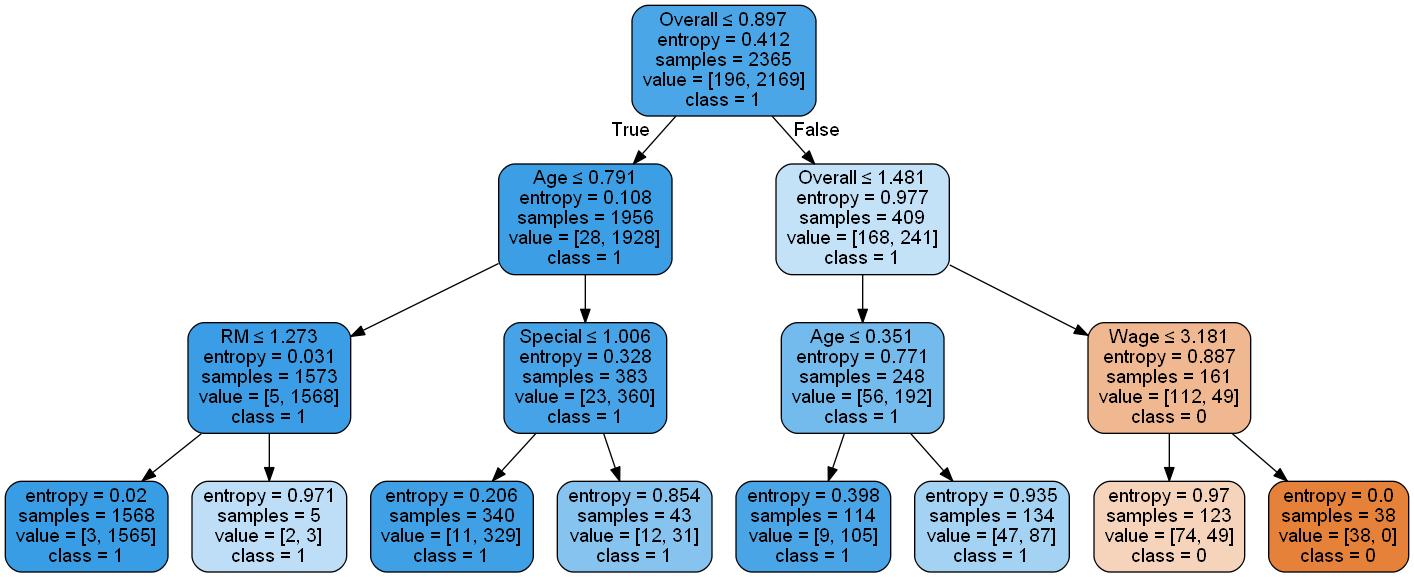

-----------
Decision Tree for rating score  2


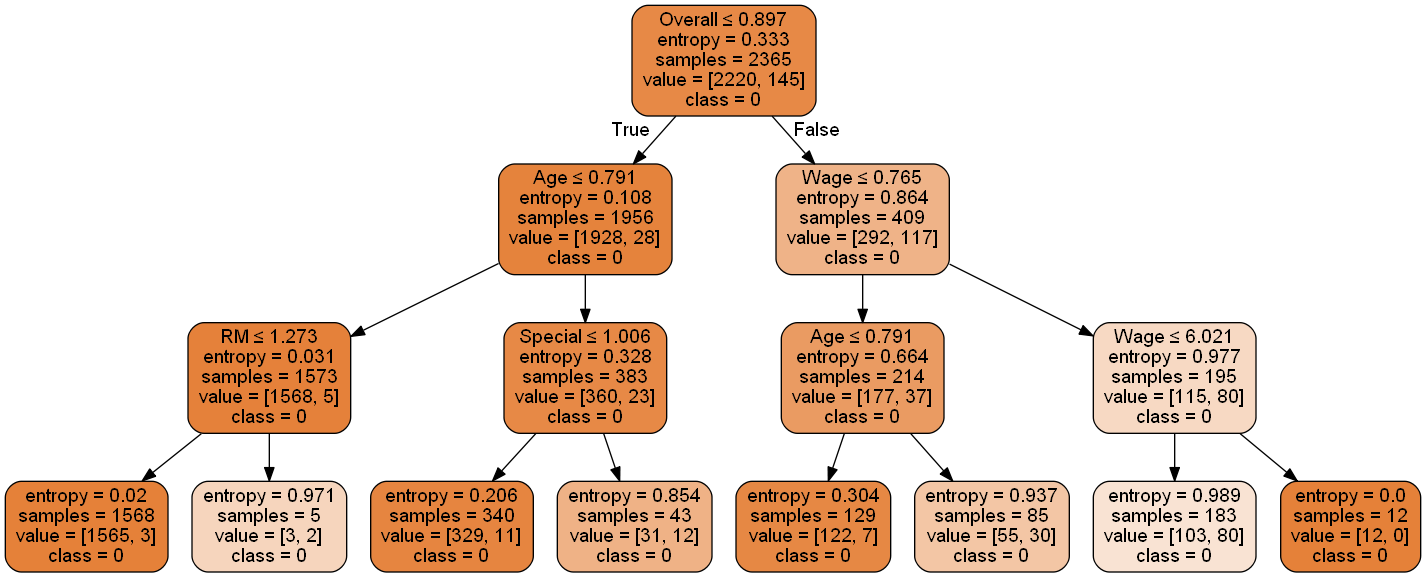

-----------
Decision Tree for rating score  3


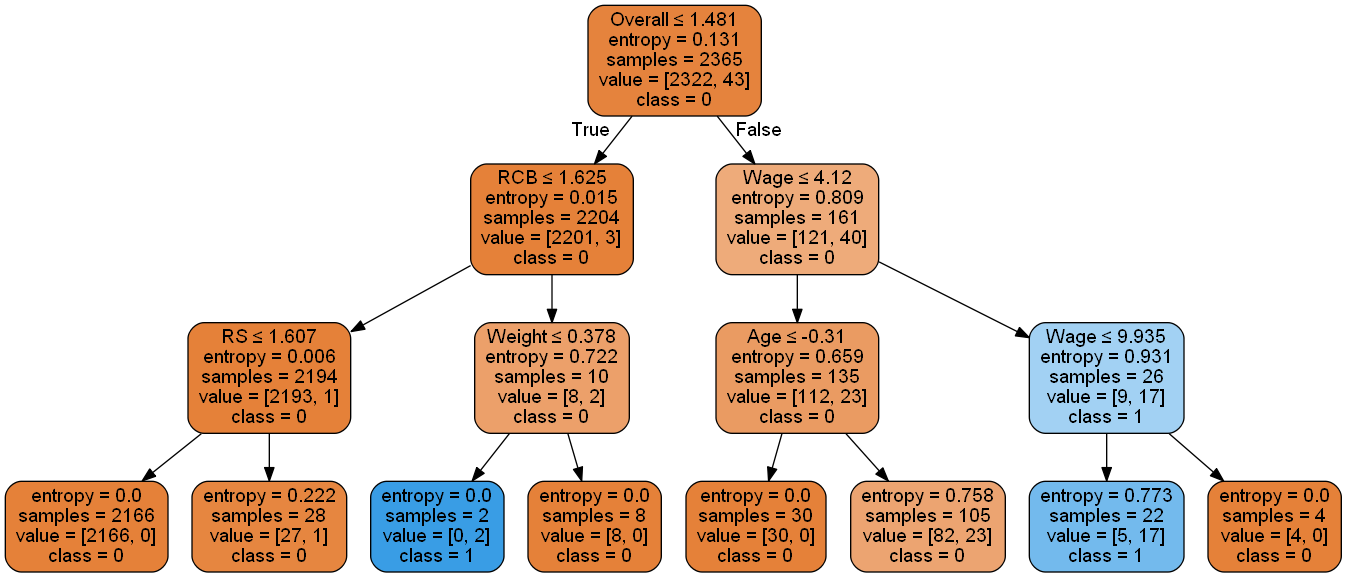

-----------
Decision Tree for rating score  4


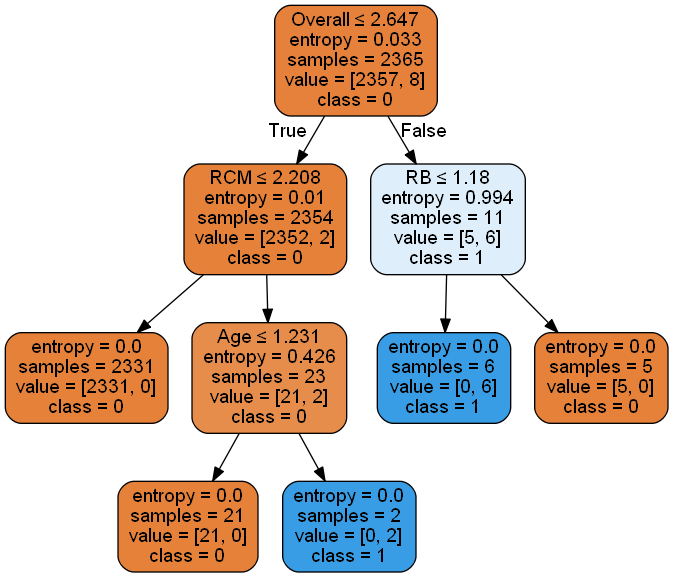

-----------


In [75]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#DT visualizatin method 3
#!conda install -y pydotplus
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image, display
import pydotplus
import os
os.environ["PATH"] += os.pathsep + 'D:/App/Graphviz2.38/bin/'

def show_decision_tree(decision_tree_model, features, out_png_file='decision_tree.png', classes=['0', '1']):
    dot_data = StringIO()
    export_graphviz(decision_tree_model, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True,feature_names=features, class_names=classes)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png(out_png_file)
    img = Image(filename = out_png_file)
    display(img)

for i in range(n_classes):
    rating_score = i + 1
    print('Decision Tree for rating score ', rating_score)
    out_png_file = 'decision_tree{}.png'.format(rating_score)
    show_decision_tree(best_decision_tree.best_estimator_.estimators_[i], X.columns, out_png_file=out_png_file)
    print("-----------")

In [76]:
#Step 5. Choose Best model

In [77]:
# Store best results for different model
avail_models = [
    {'name': 'Logistic Regression', 'roc_auc': roc_logreg},
    {'name': 'Naive Bayes', 'roc_auc': roc_gaussian_proc},
    {'name': 'Decision Tree', 'roc_auc': roc_decision_tree}
]

# Sort based on ROC area values
avail_models.sort(key=lambda sortKey : sortKey['roc_auc'], reverse=True)
print([(model['name'], model['roc_auc']) for model in avail_models])

[('Naive Bayes', 0.9652793381876914), ('Logistic Regression', 0.9583273221314677), ('Decision Tree', 0.8324146474227702)]


In [78]:
# We will compare and choose the best model to estimate the results,
# so Naive Bayes are selected
best_model_name, best_roc_auc = (avail_models[0]['name'], avail_models[0]['roc_auc'])
print('best_model_name: {0}, best_roc_auc: {1:0.4f}'.format(best_model_name, best_roc_auc))

best_model_name: Naive Bayes, best_roc_auc: 0.9653
